# Bonus part: Image classification using SIFT    
In this notebook I try to use SIFT features to train a linear classifier for image classification tasks.

In [9]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import cv2

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


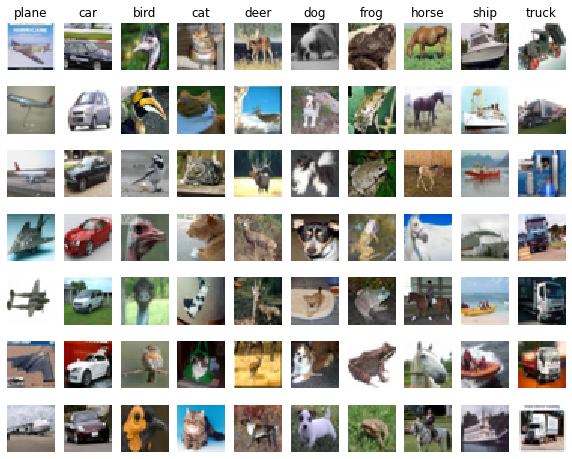

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
from cs231n.classifiers import LinearSVM
from cs231n.classifiers import Softmax

Below I define the **sift_transform** function that computes the sift features for each image. The *n_des* parameter represents how much feature vector we choose to use out of the many vectors produced by the SIFT algorithm. Since each vector is of length 128, our final feature vector for one training example would be of length 128$\times$*n_des*.

In [55]:
def sift_transform(X, n_des):
    N = X.shape[0]
    X_sift = np.zeros((N, 128*n_des))
    for i in range(N):
        img1 = X[i].astype('uint8')
        gray1 = cv2.cvtColor(img1.astype('uint8'), cv2.COLOR_BGR2GRAY)

        #keypoints
        sift = cv2.SIFT_create()
        keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
        if not(descriptors_1 is None):
            des_selected = descriptors_1[np.random.randint(descriptors_1.shape[0], size=n_des)]
            X_sift[i] = des_selected.flatten()
    return X_sift

The **transform_and_train** function defined below is for training the classifier using the transformed training data. The hyperparameters can also be chosen.

In [30]:
def transform_and_train(X, y, n_des=20, model='svm', lr=1e-4, reg=0, n_iter=1000):
    X_sift = sift_transform(X, n_des)
    #classifier = None
    if model == 'softmax':
        classifier = Softmax()  
    
    classifier = LinearSVM()
    
    classifier.train(X_sift, y, learning_rate=lr, reg=reg, num_iters=n_iter)
        
    # training accuracy
    y_pred = classifier.predict(X_sift)
    print('training accuracy: %f' % (np.mean(y == y_pred), ))
    return classifier

First, I tried out the pipeline on the **X_dev** and **y_dev** to see how it performs. The training accuracy reached 100% due to the small size of the dataset. However, the validation accuracy is quite low, only 15.5%.

In [31]:
mod = transform_and_train(X_dev, y_dev, model='softmax', reg=1)
y_pred = mod.predict(sift_transform(X_val, 20))
val_accuracy = np.mean(y_val == y_pred)
print("validation accuracy", val_accuracy)

training accuracy: 1.000000
validation accuracy 0.155


Next, I tried to train the model with the whole **X_train** and **y_train**. Meanwhile, I used a grid search to find the optimal hyperparameters.

In [32]:
n_dess = [40, 30, 20]
learning_rates = [1e-3, 1e-4, 1e-5]
regularization_strengths = [1, 10, 100]

grid_search = [ (n,lr,reg) for n in n_dess for lr in learning_rates for reg in regularization_strengths ]

for n, lr, reg in grid_search:
    mod = transform_and_train(X_train, y_train, n, lr, reg)
    y_pred = mod.predict(sift_transform(X_val, n))
    val_accuracy = np.mean(y_val == y_pred)
    print('n_des %f lr %e reg %e val accuracy: %f' % (
                n, lr, reg, val_accuracy))
    

training accuracy: 0.217694
n_des 40.000000 lr 1.000000e-03 reg 1.000000e+00 val accuracy: 0.183000
training accuracy: 0.247143
n_des 40.000000 lr 1.000000e-03 reg 1.000000e+01 val accuracy: 0.172000
training accuracy: 0.246531
n_des 40.000000 lr 1.000000e-03 reg 1.000000e+02 val accuracy: 0.179000
training accuracy: 0.192755
n_des 40.000000 lr 1.000000e-04 reg 1.000000e+00 val accuracy: 0.162000
training accuracy: 0.196633
n_des 40.000000 lr 1.000000e-04 reg 1.000000e+01 val accuracy: 0.148000
training accuracy: 0.195020
n_des 40.000000 lr 1.000000e-04 reg 1.000000e+02 val accuracy: 0.181000
training accuracy: 0.223918
n_des 40.000000 lr 1.000000e-05 reg 1.000000e+00 val accuracy: 0.186000
training accuracy: 0.216939
n_des 40.000000 lr 1.000000e-05 reg 1.000000e+01 val accuracy: 0.184000
training accuracy: 0.223857
n_des 40.000000 lr 1.000000e-05 reg 1.000000e+02 val accuracy: 0.202000
training accuracy: 0.178286
n_des 30.000000 lr 1.000000e-03 reg 1.000000e+00 val accuracy: 0.120000


From the outputs above, we can tell that the best set of hyperparameter is {n_des: 40, learning_rate: 1e-5, regularization: 100}. Now we evaluate the performance on the test set.

In [34]:
final_model = transform_and_train(X_train, y_train, 40, 1e-5, 100)
y_pred = final_model.predict(sift_transform(X_test, 40))
print("Test accuracy:", np.mean(y_test == y_pred))

training accuracy: 0.236918
Test accuracy: 0.194


In [ ]:
from sklearn.neural_network import MLPClassifier

n=50
# X = sift_transform(X_dev, n)
# y = y_dev
X = sift_transform(X_train, n)
y = y_train
fnn = MLPClassifier(hidden_layer_sizes=tuple([50]*50), 
                    max_iter=1000, early_stopping=False).fit(X, y)
print(np.mean(y == fnn.predict(X)))
print(np.mean(y_val == fnn.predict(sift_transform(X_val, n))))

## Remarks
We can see that the test accuracy is only 19.4%, which is quite unsatisfying even compared to knn. I suspect the major reason for this is that our input images of each class are not photos of the same objects shot from different angles. Instead, there are numerous different objects, yet of the same class. This makes the SIFT features weak in labeling distinct objects from the same class. Another reason may be that our input images have low resolutions, so that the SIFT features can be well generalized, causing a poor performance.